In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import scipy.constants as sci
from scipy.optimize import curve_fit
plt.rcParams["font.family"] = "Arial"
DPI = 300
Z = 22
TEMP = 310
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.4
from scipy.interpolate import Rbf
from sklearn.metrics import mean_squared_error

In [141]:
deg_pols = 21
Xini = 2.88
Xfin = 6.0

np_labels = ["N0", "N8", "N16", "N24", "N32", "N40", "N48", "N56", "N64", "N72", "N80", "N88", "N96", "N104"]
ion_labels = ["I0", "I10", "I20", "I50", "I90", "I150"]
q_vals = [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]
q_vals = np.array(q_vals)/21.24 #4pi(1.3)^2
center_q_vals = np.round((q_vals[1:][::2]+q_vals[:-1][::2])/2,1)
n_q_show = len(center_q_vals)
i_vals = [0, 30, 70, 170, 300, 500]
n_ion = len(i_vals)
n_np = len(q_vals)
c_np = cm.Blues(np.linspace(0.3, 1, len(np_labels)))
c_ion = cm.YlOrRd(np.linspace(0.3, 1, len(ion_labels)))
X = np.linspace(Xini, Xfin, 200)

In [3]:
def read_file(fname):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    data = []
    for line in fl:
        if "#" not in line and "@" not in line:
            data.append(line.split())
    data = np.array(data, dtype = 'float')
    data = np.nan_to_num(data)
    return data

def ma(data, n):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=n:
            moving_ave = (cumsum[i] - cumsum[i-n])/n
            moving_aves.append(moving_ave)
    return moving_aves
    
def clean_pmf(pmf, new_space, fit=False, deg_pols=deg_pols):
    pmf[:,1] = pmf[:,1] - np.mean(pmf[-10:,1])
    if fit:
        pol_av = np.poly1d(np.polyfit(pmf[:,0], pmf[:,1], deg_pols))
        new_pmf = np.zeros((len(new_space),2))
        new_pmf[:,0] = new_space
        new_pmf[:,1] = pol_av(new_space)
    else:
        new_pmf = pmf*1
    return new_pmf

In [4]:
def hamaker(rs, n_density, sigma=0.47, epsilon=3.5, np_radius=1.3):
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [5]:
def hamaker_cv1(cv1s, np_radius, n_density=10.06, sigma=0.47, epsilon=3.5):
    d = 0.52
    rs = cv1s+2*np_radius+d
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [6]:
vdw_contribution = read_file("T2/PMF_L_ann/T2-N0-I0_L_PMF.xvg")
vdw_contribution = clean_pmf(vdw_contribution, X, fit=True)
vdw_contribution = vdw_contribution[:,1]

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


In [7]:
popt, pcov = curve_fit(hamaker, X, vdw_contribution, p0=2)
best_density = popt[0]
ham_pot = hamaker(X, n_density=best_density)
diff_dimer = vdw_contribution[0]-ham_pot[0]
print("Best density: {:.2f} (sites nm-3)".format(best_density))
print("PMF dimerization energy: {:.2f} kcal mol-1".format(vdw_contribution[0]))
print("Hamaker dimerization energy: {:.2f} kcal mol-1".format(ham_pot[0]))
print("Difference in energy at contact: {:.2f} (kcal mol-1)".format(diff_dimer))

rms = math.sqrt(mean_squared_error(vdw_contribution, ham_pot))
print("RMSE: {:.2f} kcal mol-1".format(rms))

Best density: 26.45 (sites nm-3)
PMF dimerization energy: -28.64 kcal mol-1
Hamaker dimerization energy: -29.69 kcal mol-1
Difference in energy at contact: 1.05 (kcal mol-1)
RMSE: 1.60 kcal mol-1


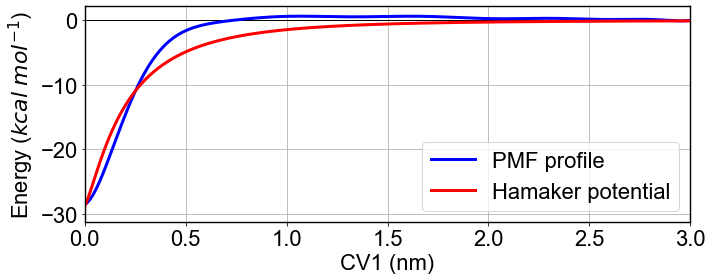

In [8]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.grid()
ax.set_xlabel("CV1 (nm)", fontsize=Z)
ax.set_ylabel(r"Energy ($kcal$ $mol^{-1}$)", fontsize=Z)
ax.axhline(0, c='k', lw=1)
ax.plot(X-2.9, vdw_contribution, c='b', lw=3, label='PMF profile')
ax.plot(X-2.9, hamaker(X, best_density), lw=3, c='r', label='Hamaker potential')
ax.set_xlim(0,3)
ax.legend(loc='lower right', fontsize=Z)
plt.tight_layout()
#plt.savefig("hamaker.png", format='png', dpi=DPI)
plt.show()
plt.close()

In [9]:
PMFann = []
for np_lab in np_labels:
    pmfann_ion = []
    pmfann_ion_hist = []
    for ion_lab in ion_labels:
        pmfann = read_file("T2/PMF_L_ann/T2-{}-{}_L_PMF.xvg".format(np_lab, ion_lab))
        if np_lab=="N96" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I0":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=16)
        if np_lab=="N104" and ion_lab=="I10":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=12)
        if np_lab=="N104" and ion_lab=="I20":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I50":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=10)
        else:
            pmfann = clean_pmf(pmfann, X, fit=True)
        pmfann_ion.append(pmfann)

    PMFann.append(pmfann_ion)
PMFann = np.array(PMFann)
print(np.shape(PMFann))

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poor

(14, 6, 200, 2)


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poor

In [10]:
PMFann[9,1,:,1] = (PMFann[8,1,:,1]+PMFann[10,1,:,1])/2  #Interpolates N72-I10
PMFann[11,5,:,1] = (PMFann[10,5,:,1]+PMFann[12,5,:,1])/2 #Interpolates N88-I150
#PMFann[12,4,:,1] = (PMFann[11,4,:,1]+PMFann[13,4,:,1])/2 #Interpolates N96-I90

In [11]:
for i in range(len(PMFann)):
    for j in range(len(PMFann[0])):
        PMFann[i,j,:,1] = PMFann[i,j,:,1] - vdw_contribution

# Electrostatic contributions

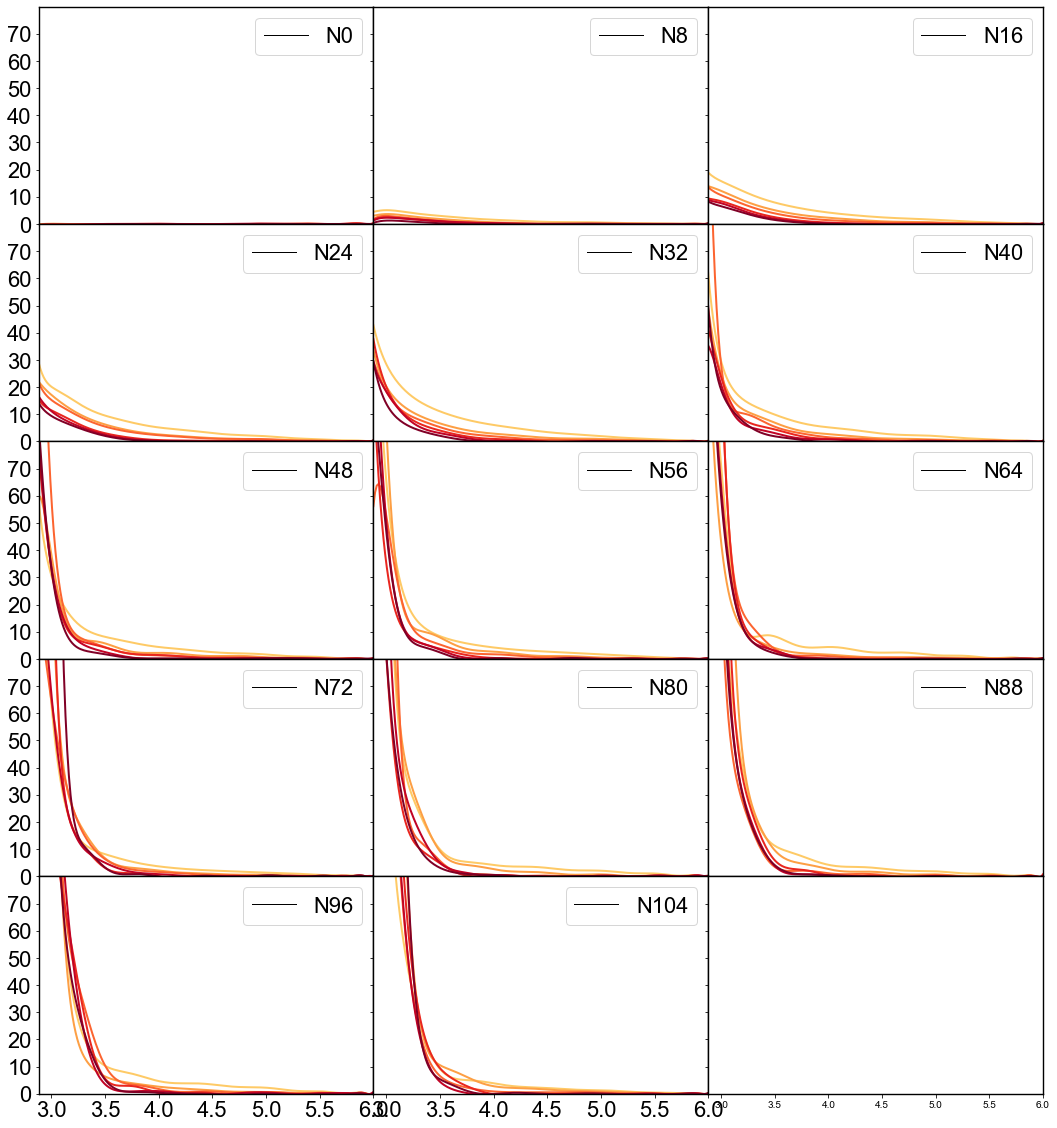

In [12]:
n_cols = 3
n_rows = 5
subplot_kw={'xlim':(Xini, Xfin), 'xticks':np.arange(3,6.1,0.5), 'ylim':(0, 80), 'yticks':np.arange(0, 80, 10)}
gridspec_kw={'hspace':0, 'wspace': 0}
fig, axs = plt.subplots(figsize=(6*n_cols, 4*n_rows), ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)
for ax, PMFs, np_lab in zip(axs.flatten(), PMFann, np_labels):
    ax.tick_params(labelsize=Z)
    ax.axhline(y=0, lw=1, c='k', label=np_lab)
    ax.legend(loc='upper right', fontsize=Z)
    for pmf, c in zip(PMFs, c_ion):
        ax.plot(pmf[:,0], pmf[:,1], color=c, lw=2)
plt.show()
plt.close()

# Phase diagrams

In [13]:
def dimer_frac(dg, c):
    R = sci.R/4184 #J mol-1 K-1 to kcal mol-1 K-1
    K_eq = np.exp(-dg/(R*TEMP))
    frac_p = (1+4*c*K_eq + np.sqrt(8*c*K_eq+1))/(8*K_eq)
    frac_m = (1+4*c*K_eq - np.sqrt(8*c*K_eq+1))/(8*K_eq)
    frac_p, frac_m = 2*frac_p/c, 2*frac_m/c #the 2 comes from stoichiometry, but careful. The dissociation fraction is twice the association fraction!
    return 1-frac_m

In [14]:
def build_agg_map_size(conc, np_radius, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    fracs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1]
            xs.append(j)
            ys.append(i)
            fracs.append(dimer_frac(dg_val, conc))
            
    #interpolation
    rbf = Rbf(xs, ys, fracs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

0.5597194388777555
0.5695390781563127
0.6677354709418838
0.854308617234469
0.9132264529058116


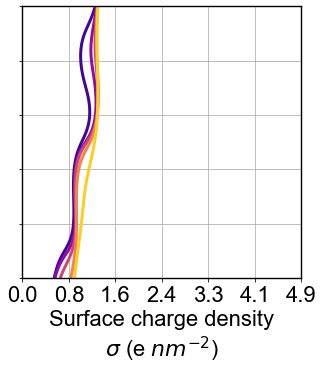

1.2372745490981965
1.286372745490982
1.3158316633266534
1.3158316633266534
1.3158316633266534


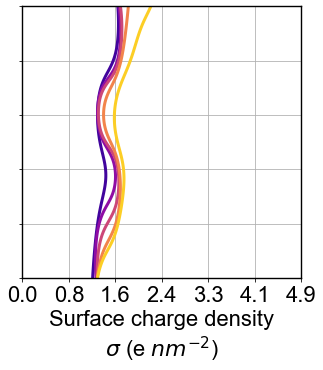

1.718436873747495
1.8559118236472945
2.268336673346693
2.3763527054108216
2.405811623246493


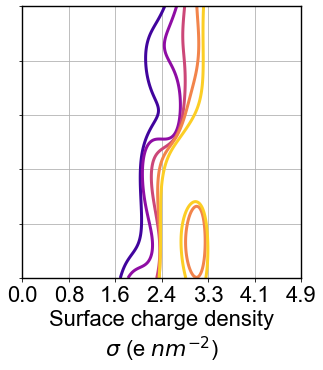

2.405811623246493
2.405811623246493
2.405811623246493
2.4156312625250504
2.48436873747495


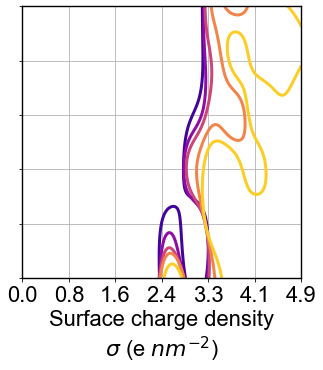

In [15]:
c_ini, c_fin = -10, -6
rs = [1.3]#, 1.6, 2,2.3]
n_concs = c_fin-c_ini+1
concs = np.logspace(c_ini, c_fin, n_concs)
c_agg = cm.plasma(np.linspace(0.1, 0.9, n_concs))

for i, r in enumerate(rs, 1):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    for conc, c in zip(concs, c_agg):
        sx, sy, agg_map = build_agg_map_size(conc, np_radius=r)
        print(np.min(sx[np.logical_and(agg_map>=0.49, agg_map<=0.51)])/13*4.9)
        ax.contour(sx, sy, agg_map, levels=np.array([0.5]), colors=[c], linewidths=[3])
    ax.set_xticks(np.linspace(0, np.max(sx), 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, np.max(sy), n_ion))
    #ax.set_yticklabels(i_vals)
    ax.set_yticklabels([])
    ax.grid()
    ax.set_xlabel("Surface charge density\n" + r"$\sigma$ (e $nm^{-2}$)", fontsize=Z)
    #ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    ax.tick_params(labelsize=Z)
    plt.savefig("PhaseDiagram_Lann_contour_r{}.png".format(r), format='png', dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close()

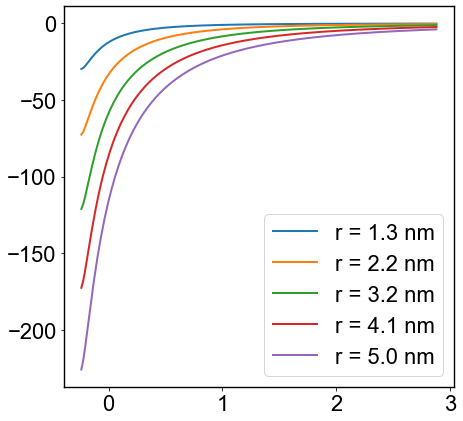

In [16]:
rs = np.linspace(1.3, 5, 5)
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.tick_params(labelsize=Z)
for r in rs:
    x_start = 2*r+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    y = hamaker(new_X, n_density=best_density, np_radius=r)
    ax.plot(new_X-2*r-0.52, y, lw=2, label='r = {} nm'.format(round(r, 1)))
ax.legend(fontsize=Z)
plt.show()
plt.close()

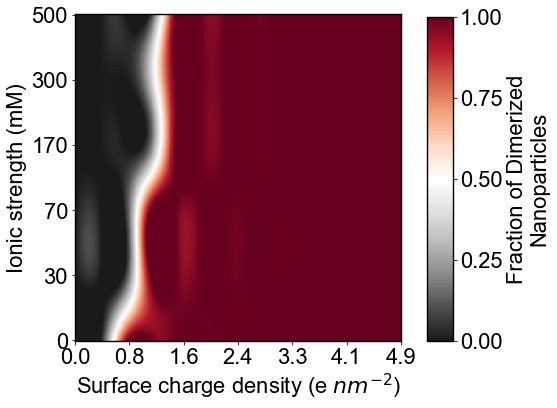

In [17]:
cmap='RdGy_r'
sx, sy, agg_map = build_agg_map_size(10**-9, np_radius=1.3)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(agg_map)-1, 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_yticks(np.linspace(0, len(agg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(agg_map, cmap=cmap, vmin=0, vmax=1, origin='lower')

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[0, 0.25, 0.5, 0.75, 1.0])
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Fraction of Dimerized\nNanoparticles", fontsize=Z)
#plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

In [18]:
ndx_never_agg = (np.where(np.all(agg_map>0.9, axis=0))[0][0])
ndx_always_agg = (np.where(np.all(agg_map<0.1, axis=0))[0][-1])
ndx_space = np.linspace(0, len(sx)-1, len(q_vals))
ndx_q_func = np.poly1d(np.polyfit(ndx_space, q_vals, 1))
q_never_agg = ndx_q_func(ndx_never_agg)
q_always_agg = ndx_q_func(ndx_always_agg)
print("There is never aggregation after {:.2f} e nm-2. Total Q = {:.2f}".format(q_never_agg, q_never_agg*21.24))
print("There is always aggregation before {:.2f} e nm-2. Total Q = {:.2f}".format(q_always_agg, q_always_agg*21.24))

There is never aggregation after 1.46 e nm-2. Total Q = 31.05
There is always aggregation before 0.42 e nm-2. Total Q = 8.96


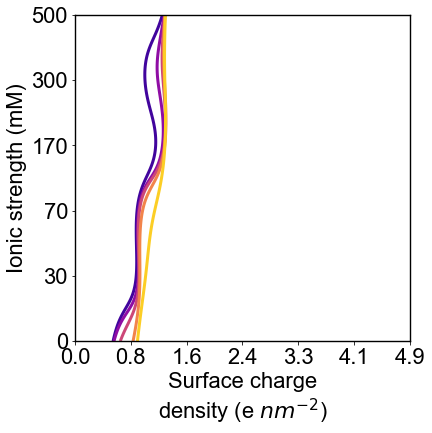

In [19]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
for conc, c in zip(concs, c_agg):
    sx, sy, agg_map = build_agg_map_size(conc, np_radius=1.3)
    ax.contour(sx, sy, agg_map, levels=np.array([0.5]), colors=[c], linewidths=[3])
#ax.set_xticks(np.linspace(0,np.max(sx), n_np//2))
#ax.set_xticklabels(np.round(q_vals[::2], 1))
ax.set_xticks(np.linspace(0, np.max(sx), 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))

ax.set_yticks(np.linspace(0, np.max(sy), n_ion))
ax.set_yticklabels(i_vals)
#ax.set_yticklabels([])
ax.set_xlabel("Surface charge\ndensity "+r"(e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
ax.tick_params(labelsize=Z)
plt.savefig("PhaseDiagram_Lann_contour.png", format='png', dpi=DPI, bbox_inches='tight')
plt.show()
plt.close()

# Free energy maps

In [15]:
zeta_cont = np.loadtxt("contout3mV.csv", delimiter=',')

In [89]:
def build_dg_map_size(np_radius, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
            #print(hamaker(new_X, n_density=best_density, np_radius=np_radius)[0])
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1]
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
           
    dgs = np.array(dgs).reshape(6,14)
    dgs[4,9] = 0.66*dgs[4,8] + 0.33*dgs[4,11]
    dgs[4,10] = 0.33*dgs[4,8] + 0.66*dgs[4,11]
    dgs[3,4] = 0.5*(dgs[3,3] + dgs[3,5])+0.5
    dgs[5,10] = 0.5*(dgs[5,9] + dgs[5,11])
    dgs = dgs.flatten()

    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

In [128]:
colors_cmap = [(0.7,0.7,0.5),
               (0.9,0.8,0.8),
              (0.9,1.0,0.9),
              (0.6,0.8,0.9),
              (0.4,0.8,0.9)]
my_cm = LinearSegmentedColormap.from_list(
        "my_cm", colors_cmap, N=100)

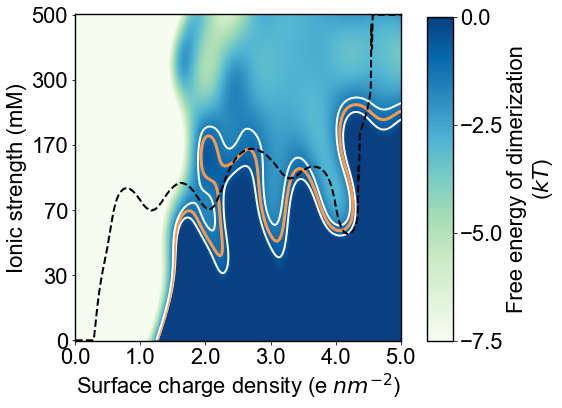

In [143]:
kT = 0.617
cmap='GnBu'
sx, sy, dg_map = build_dg_map_size(np_radius=1.3)
dg_map = dg_map/kT
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 6))
#ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_xticklabels(np.linspace(0,5,6))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-7.5, vmax=0)
ax.contour(dg_map, levels=np.array([-0.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1]), colors=[(1,0.6,0.3)], linewidths=[3], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
#cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-5*kT, vmax=0)
#ax.contour(dg_map, levels=np.array([-0.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-1.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-2*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=2, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=np.linspace(-7.5,0,4))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"($kT$)", fontsize=Z)
plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

NP radius: 1.3


KeyboardInterrupt: 

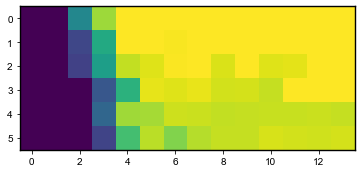

In [79]:
cmap='GnBu'
rs = [1.3, 1.5, 1.7, 1.9, 2.1]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_size(np_radius=r)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
    #ax.contour(dg_map, levels=np.array([-0.6]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(dg_map, levels=np.array([-1.2]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    #ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()

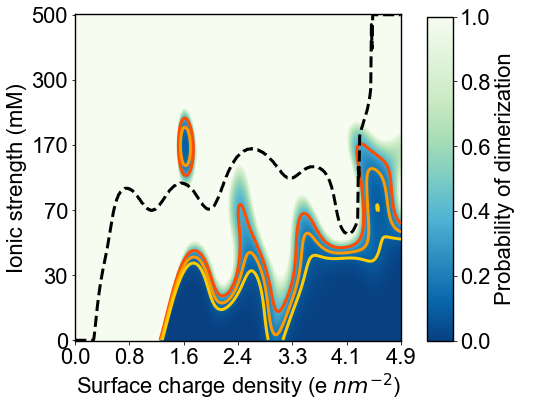

In [60]:
cmap='GnBu_r'
sx, sy, dg_map = build_dg_map_size(np_radius=1.3)
prob_map = np.exp(-dg_map/0.593)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(prob_map)-1, 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_yticks(np.linspace(0, len(prob_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(prob_map, cmap=cmap, origin='lower', vmin=0, vmax=1)
#ax.contour(prob_map, levels=np.array([0.63]), colors=[(1.0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.37]), colors=[(1.0,0.3,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.185]), colors=[(1.0,0.6,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.0925]), colors=[(1.0,0.8,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a)#, ticks=[-30, -20, -10, 0, 10])
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Probability of dimerization\n", fontsize=Z)
#plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

NP radius: 1.3


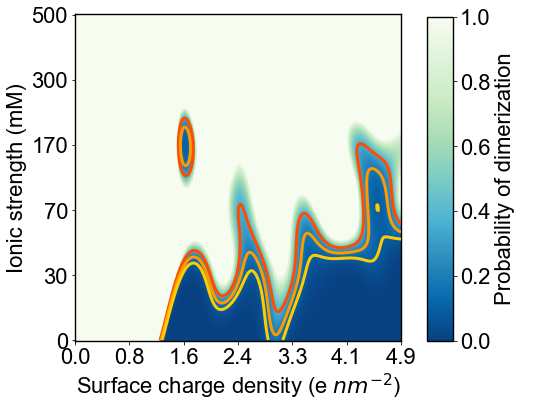

NP radius: 1.5


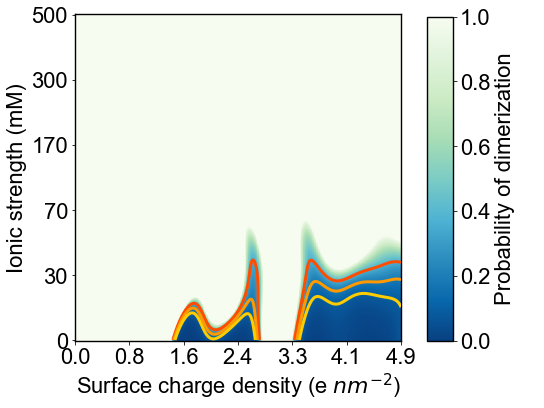

NP radius: 1.7


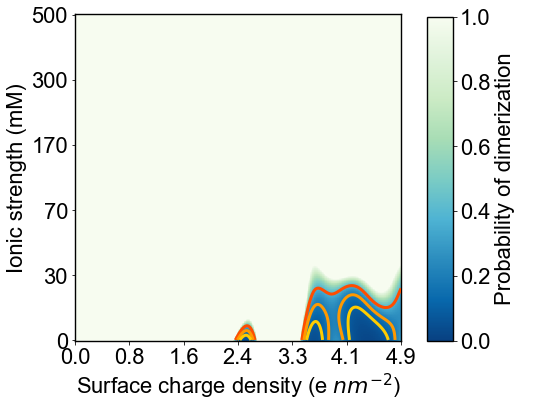

NP radius: 1.9


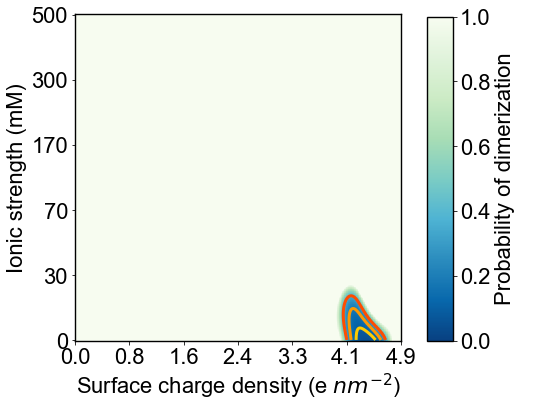

NP radius: 2.1


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


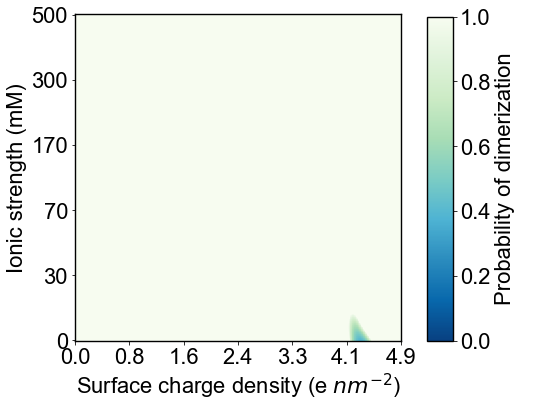

In [35]:
cmap='GnBu_r'
rs = [1.3, 1.5, 1.7, 1.9, 2.1]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_size(np_radius=r)
    prob_map = np.exp(-(dg_map)/0.593)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(prob_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(prob_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(prob_map, cmap=cmap, origin='lower', vmin=0, vmax=1)
    #ax.contour(prob_map, levels=np.array([0.63]), colors=[(1.0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.37]), colors=[(1.0,0.3,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.185]), colors=[(1.0,0.6,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.0925]), colors=[(1.0,0.8,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')

    #ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a)#, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Probability of dimerization\n", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()

# Free energy maps pseudo-size

In [61]:
def build_dg_map_pseudosize(np_radius, n_density, n_pts=500):
    cv1 = np.linspace(0,3,200)
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker_cv1(cv1, n_density=n_density, np_radius=np_radius)
            #pmf[:,1] += hamaker(new_X, n_density=n_density, np_radius=np_radius)
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]-2*1.3-0.52<0.7,1])
            dg_val = pmf[ndx,1]
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
            
    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


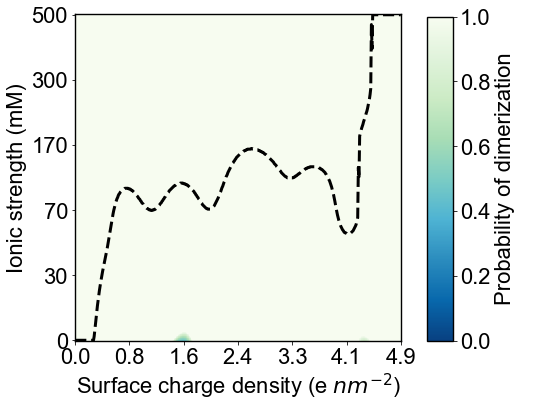

In [63]:
cmap='GnBu_r'
sx, sy, dg_map = build_dg_map_pseudosize(np_radius=7.45, n_density=10.06)
prob_map = np.exp(-dg_map/0.593)*2
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(prob_map)-1, 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_yticks(np.linspace(0, len(prob_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(prob_map, cmap=cmap, origin='lower', vmin=0, vmax=1)
#ax.contour(prob_map, levels=np.array([0.63]), colors=[(1.0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.37]), colors=[(1.0,0.3,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.185]), colors=[(1.0,0.6,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(prob_map, levels=np.array([0.0925]), colors=[(1.0,0.8,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a)#, ticks=[-30, -20, -10, 0, 10])
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Probability of dimerization\n", fontsize=Z)
#plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

NP radius: 3.5


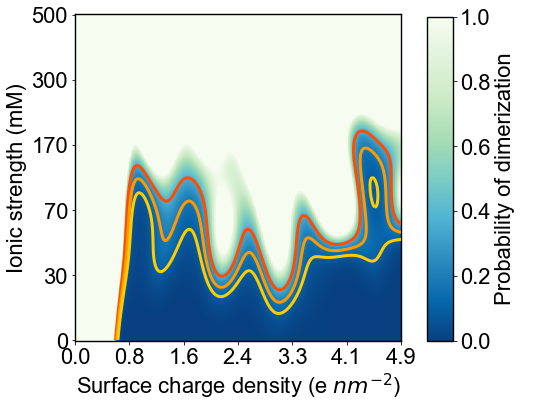

NP radius: 5.5


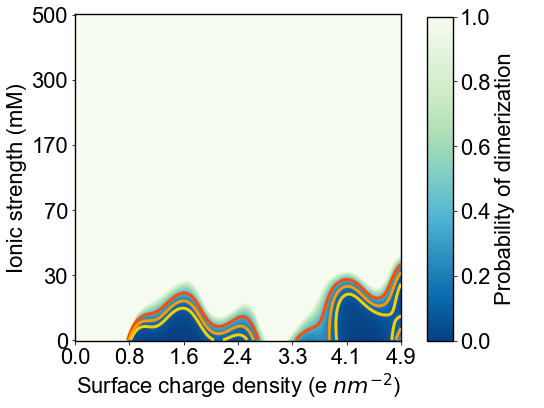

NP radius: 7.45


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


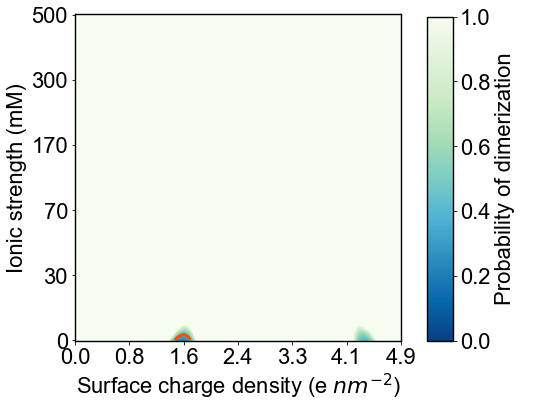

NP radius: 9.5


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


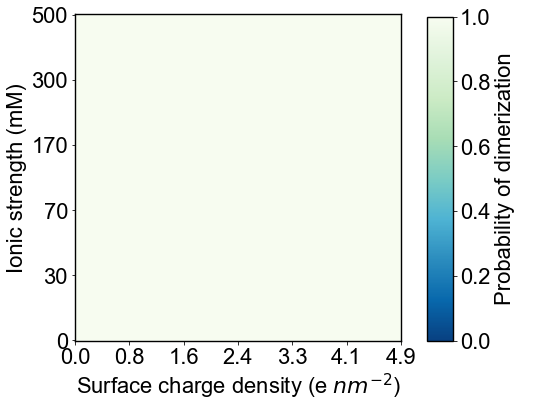

In [64]:
cmap='GnBu_r'
rs = [3.5, 5.5, 7.45, 9.5]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_pseudosize(np_radius=r, n_density=10.06)
    prob_map = np.exp(-(dg_map)/0.593)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(prob_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(prob_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(prob_map, cmap=cmap, origin='lower', vmin=0, vmax=1)
    #ax.contour(prob_map, levels=np.array([0.63]), colors=[(1.0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.37]), colors=[(1.0,0.3,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.185]), colors=[(1.0,0.6,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    ax.contour(prob_map, levels=np.array([0.0925]), colors=[(1.0,0.8,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')

    #ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a)#, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Probability of dimerization\n", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()

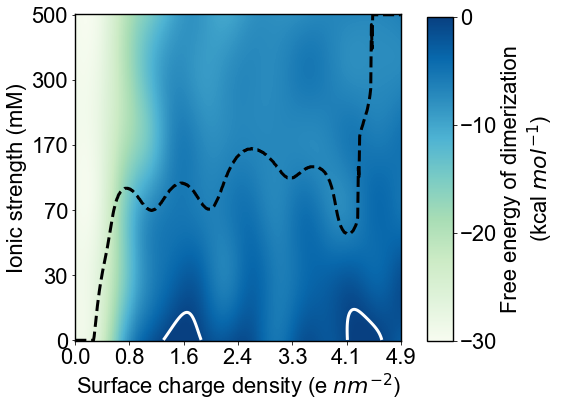

In [58]:
cmap='GnBu'
sx, sy, dg_map = build_dg_map_pseudosize(np_radius=7.45, n_density=10.06)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
ax.contour(dg_map, levels=np.array([-0.593]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-30, -20, -10, 0, 10])
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
#plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

NP radius: 3.5


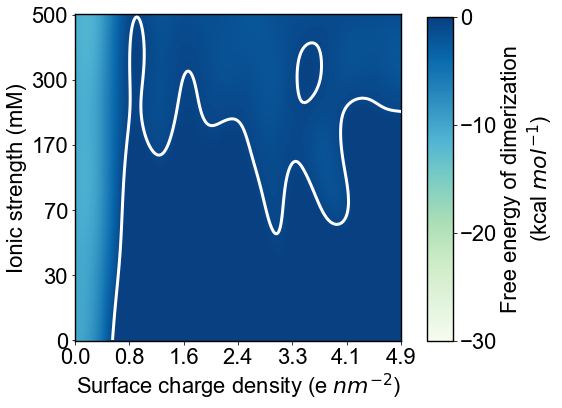

NP radius: 5.5


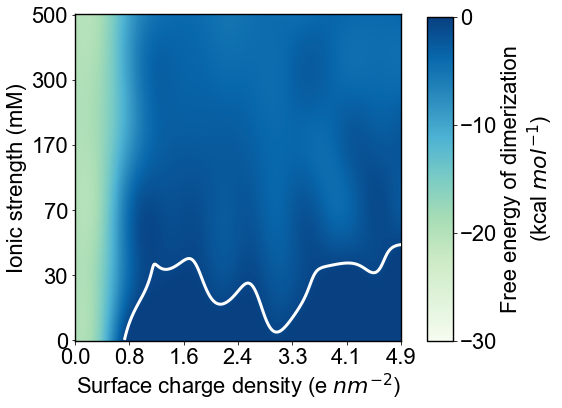

NP radius: 7.45


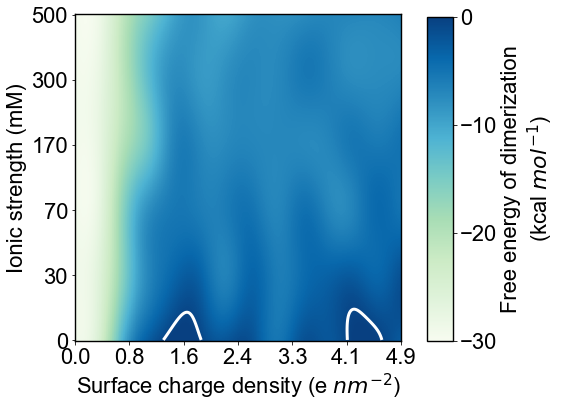

NP radius: 9.5


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()


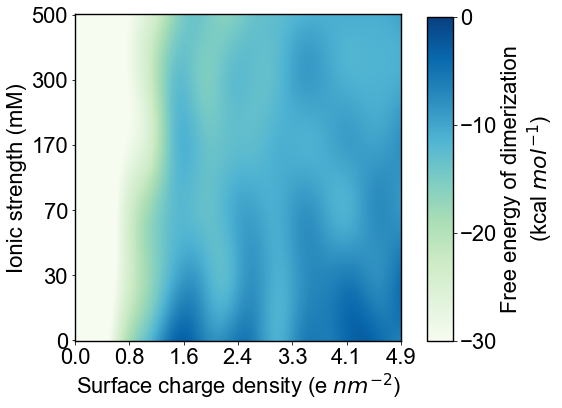

In [59]:
cmap='GnBu'
rs = [3.5, 5.5, 7.45, 9.5]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_pseudosize(np_radius=r, n_density=10.06)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
    ax.contour(dg_map, levels=np.array([-0.6]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    #ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()